# U-Net for cell segentation

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch

"""
    This file defines every layer (or group of layers) that are inside UNet.
    At the final the architecture UNet is defined as a conjuntion of the elements created.
"""
class double_conv(nn.Module):
    ''' Applies (conv => BN => ReLU) two times. '''

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            # inplace is for aply ReLU to the original place, saving memory
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            # inplace is for aply ReLU to the original place, saving memory
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    ''' First Section of U-Net. '''

    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    ''' Applies a MaxPool with a Kernel of 2x2,
        then applies a double convolution pack. '''

    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()

        self.mpconv = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    ''' Applies a Deconvolution and then applies applies a double convolution pack. '''

    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()

        # Bilinear is used to save computational cost
        if bilinear:
            self.up = nn.Upsample(
                scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(
                in_ch//2, in_ch//2, kernel_size=2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(input=x2, pad=(diffX // 2, diffX // 2,
                                  diffY // 2, diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    ''' Applies the last Convolution to give an answer. '''

    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()

        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    ''' This Object defines the architecture of U-Net. '''

    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()

        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [ ]:
import math

import cv2
import matplotlib.cm as cm
import numpy as np

from scipy import ndimage
from scipy.ndimage import measurements
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import affine_transform, map_coordinates

from skimage import morphology as morph

####
def fix_mirror_padding(ann):
    """Deal with duplicated instances due to mirroring in interpolation
    during shape augmentation (scale, rotation etc.).

    """
    current_max_id = np.amax(ann)
    inst_list = list(np.unique(ann))
    inst_list.remove(0)  # 0 is background
    for inst_id in inst_list:
        inst_map = np.array(ann == inst_id, np.uint8)
        remapped_ids = measurements.label(inst_map)[0]
        remapped_ids[remapped_ids > 1] += current_max_id
        ann[remapped_ids > 1] = remapped_ids[remapped_ids > 1]
        current_max_id = np.amax(ann)
    return ann


####
def gaussian_blur(images, random_state, parents, hooks, max_ksize=3):
    """Apply Gaussian blur to input images."""
    img = images[0]  # aleju input batch as default (always=1 in our case)
    ksize = random_state.randint(0, max_ksize, size=(2,))
    ksize = tuple((ksize * 2 + 1).tolist())

    ret = cv2.GaussianBlur(
        img, ksize, sigmaX=0, sigmaY=0, borderType=cv2.BORDER_REPLICATE
    )
    ret = np.reshape(ret, img.shape)
    ret = ret.astype(np.uint8)
    return [ret]


####
def median_blur(images, random_state, parents, hooks, max_ksize=3):
    """Apply median blur to input images."""
    img = images[0]  # aleju input batch as default (always=1 in our case)
    ksize = random_state.randint(0, max_ksize)
    ksize = ksize * 2 + 1
    ret = cv2.medianBlur(img, ksize)
    ret = ret.astype(np.uint8)
    return [ret]


####
def add_to_hue(images, random_state, parents, hooks, range=None):
    """Perturbe the hue of input images."""
    img = images[0]  # aleju input batch as default (always=1 in our case)
    hue = random_state.uniform(*range)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if hsv.dtype.itemsize == 1:
        # OpenCV uses 0-179 for 8-bit images
        hsv[..., 0] = (hsv[..., 0] + hue) % 180
    else:
        # OpenCV uses 0-360 for floating point images
        hsv[..., 0] = (hsv[..., 0] + 2 * hue) % 360
    ret = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    ret = ret.astype(np.uint8)
    return [ret]


####
def add_to_saturation(images, random_state, parents, hooks, range=None):
    """Perturbe the saturation of input images."""
    img = images[0]  # aleju input batch as default (always=1 in our case)
    value = 1 + random_state.uniform(*range)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret = img * value + (gray * (1 - value))[:, :, np.newaxis]
    ret = np.clip(ret, 0, 255)
    ret = ret.astype(np.uint8)
    return [ret]


####
def add_to_contrast(images, random_state, parents, hooks, range=None):
    """Perturbe the contrast of input images."""
    img = images[0]  # aleju input batch as default (always=1 in our case)
    value = random_state.uniform(*range)
    mean = np.mean(img, axis=(0, 1), keepdims=True)
    ret = img * value + mean * (1 - value)
    ret = np.clip(img, 0, 255)
    ret = ret.astype(np.uint8)
    return [ret]


####
def add_to_brightness(images, random_state, parents, hooks, range=None):
    """Perturbe the brightness of input images."""
    img = images[0]  # aleju input batch as default (always=1 in our case)
    value = random_state.uniform(*range)
    ret = np.clip(img + value, 0, 255)
    ret = ret.astype(np.uint8)
    return [ret]


####
def cropping_center(x, crop_shape, batch=False):
    """Crop an input image at the centre.

    Args:
        x: input array
        crop_shape: dimensions of cropped array

    Returns:
        x: cropped array

    """
    orig_shape = x.shape
    if not batch:
        h0 = int((orig_shape[0] - crop_shape[0]) * 0.5)
        w0 = int((orig_shape[1] - crop_shape[1]) * 0.5)
        x = x[h0 : h0 + crop_shape[0], w0 : w0 + crop_shape[1]]
    else:
        h0 = int((orig_shape[1] - crop_shape[0]) * 0.5)
        w0 = int((orig_shape[2] - crop_shape[1]) * 0.5)
        x = x[:, h0 : h0 + crop_shape[0], w0 : w0 + crop_shape[1]]
    return x



<ipython-input-2-2f42dbc83bac>:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
<ipython-input-2-2f42dbc83bac>:10: DeprecationWarning: Please use `affine_transform` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import affine_transform, map_coordinates
<ipython-input-2-2f42dbc83bac>:10: DeprecationWarning: Please use `map_coordinates` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import affine_transform, map_coordinates


In [ ]:
import csv
import glob
import os
import re

import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import torch.utils.data

import imgaug as ia
from imgaug import augmenters as iaa


####
class FileLoader(torch.utils.data.Dataset):
    """Data Loader. Loads images from a file list and
    performs augmentation with the albumentation library.
    After augmentation, horizontal and vertical maps are
    generated.

    Args:
        file_list: list of filenames to load
        input_shape: shape of the input [h,w] - defined in config.py
        mask_shape: shape of the output [h,w] - defined in config.py
        mode: 'train' or 'valid'

    """

    # TODO: doc string

    def __init__(
        self,
        file_list,
        with_type=False,
        input_shape=None,
        mask_shape=None,
        mode="train",
        setup_augmentor=True,
        target_gen=None,
    ):
        assert input_shape is not None and mask_shape is not None
        self.mode = mode
        self.info_list = file_list
        self.with_type = with_type
        self.mask_shape = mask_shape
        self.input_shape = input_shape
        self.id = 0
        self.target_gen_func = target_gen[0]
        self.target_gen_kwargs = target_gen[1]
        if setup_augmentor:
            self.setup_augmentor(0, 0)
        return

    def setup_augmentor(self, worker_id, seed):
        self.augmentor = self.__get_augmentation(self.mode, seed)
        self.shape_augs = iaa.Sequential(self.augmentor[0])
        self.input_augs = iaa.Sequential(self.augmentor[1])
        self.id = self.id + worker_id
        return

    def __len__(self):
        return len(self.info_list)

    def __getitem__(self, idx):
        path = self.info_list[idx]
        data = np.load(path)

        # split stacked channel into image and label
        img = (data[..., :3]).astype("uint8")  # RGB images
        ann = (data[..., 3:]).astype("int32")  # instance ID map and type map

        if self.shape_augs is not None:
            shape_augs = self.shape_augs.to_deterministic()
            img = shape_augs.augment_image(img)
            ann = shape_augs.augment_image(ann)

        if self.input_augs is not None:
            input_augs = self.input_augs.to_deterministic()
            img = input_augs.augment_image(img)

        img = cropping_center(img, self.input_shape)
        feed_dict = {"img": img, 'inst_map': ann[..., 0]}



        return feed_dict

    def __get_augmentation(self, mode, rng):
        if mode == "train":
            shape_augs = [
                # * order = ``0`` -> ``cv2.INTER_NEAREST``
                # * order = ``1`` -> ``cv2.INTER_LINEAR``
                # * order = ``2`` -> ``cv2.INTER_CUBIC``
                # * order = ``3`` -> ``cv2.INTER_CUBIC``
                # * order = ``4`` -> ``cv2.INTER_CUBIC``
                # ! for pannuke v0, no rotation or translation, just flip to avoid mirror padding
                iaa.Affine(
                    # scale images to 80-120% of their size, individually per axis
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                    # translate by -A to +A percent (per axis)
                    translate_percent={"x": (-0.01, 0.01), "y": (-0.01, 0.01)},
                    shear=(-5, 5),  # shear by -5 to +5 degrees
                    rotate=(-179, 179),  # rotate by -179 to +179 degrees
                    order=0,  # use nearest neighbour
                    backend="cv2",  # opencv for fast processing
                    seed=rng,
                ),
                # set position to 'center' for center crop
                # else 'uniform' for random crop
                iaa.CropToFixedSize(
                    self.input_shape[0], self.input_shape[1], position="center"
                ),
                iaa.Fliplr(0.5, seed=rng),
                iaa.Flipud(0.5, seed=rng),
            ]

            input_augs = [
                iaa.OneOf(
                    [
                        iaa.Lambda(
                            seed=rng,
                            func_images=lambda *args: gaussian_blur(*args, max_ksize=3),
                        ),
                        iaa.Lambda(
                            seed=rng,
                            func_images=lambda *args: median_blur(*args, max_ksize=3),
                        ),
                        iaa.AdditiveGaussianNoise(
                            loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5
                        ),
                    ]
                ),
                iaa.Sequential(
                    [
                        iaa.Lambda(
                            seed=rng,
                            func_images=lambda *args: add_to_hue(*args, range=(-8, 8)),
                        ),
                        iaa.Lambda(
                            seed=rng,
                            func_images=lambda *args: add_to_saturation(
                                *args, range=(-0.2, 0.2)
                            ),
                        ),
                        iaa.Lambda(
                            seed=rng,
                            func_images=lambda *args: add_to_brightness(
                                *args, range=(-26, 26)
                            ),
                        ),
                        iaa.Lambda(
                            seed=rng,
                            func_images=lambda *args: add_to_contrast(
                                *args, range=(0.75, 1.25)
                            ),
                        ),
                    ],
                    random_order=True,
                ),
            ]
        elif mode == "valid":
            shape_augs = [
                # set position to 'center' for center crop
                # else 'uniform' for random crop
                iaa.CropToFixedSize(
                    self.input_shape[0], self.input_shape[1], position="center"
                )
            ]
            input_augs = []

        return shape_augs, input_augs



In [ ]:
import numpy as np

class DataBowlSet(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.file_list = os.listdir(self.data_dir)


    def __getitem__(self, index):
        fil = os.path.join(self.data_dir, self.file_list[index])
        # print(fil)
        data = np.load(fil)
        img = data[..., :3].astype(np.float32)
        inst = data[..., 3]

        return img, inst, inst

    def __len__(self):
        return len(self.file_list)


# Dataset

# Train

In [ ]:
import time
import torch.nn as nn
import torch
import numpy as np
import torch.nn.functional as F

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

"""
    Class that defines the Dice Loss function.
"""
class DiceLoss(nn.Module):

    def __init__(self, smooth = 1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def dice_coef(self, y_pred, y_true):
        pred_probs = torch.sigmoid(y_pred)
        y_true_f = y_true.view(-1)
        # print(pred_probs.shape, y_true.shape)
        y_pred_f = pred_probs.view(-1)
        intersection = torch.sum(y_true_f * y_pred_f)
        return (2. * intersection + self.smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + self.smooth)

    def forward(self, y_pred, y_true):
        return -self.dice_coef(y_pred, y_true)


"""
    Class that defines the Root Mean Square Loss function.
"""
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))


"""
    Class that defines the Cross Entropy Loss Function
"""
class CELoss(nn.Module):
    def __init__(self):
        super(CELoss, self).__init__()

    def forward(self, y_pred, y_true):
        return -torch.mean(torch.sum(y_true*torch.log(F.softmax(y_pred,dim=1)),dim=1))

"""
    Class that defines the Cross Entropy Loss Function
"""
class WCELoss(nn.Module):
    def __init__(self):
        super(WCELoss, self).__init__()

    def forward(self, y_pred, y_true, weights):
        y_true = y_true/(y_true.sum(2).sum(2,dtype=torch.float).unsqueeze(-1).unsqueeze(-1))
        y_true[y_true != y_true] = 0.0
        y_true = torch.sum(y_true,dim=1, dtype = torch.float).unsqueeze(1)
        y_true = y_true * weights.to(torch.float)
        old_range = torch.max(y_true) - torch.min(y_true)
        new_range = 100 - 1
        y_true = (((y_true - torch.min(y_true)) * new_range) / old_range) + 1
        return -torch.mean(torch.sum(y_true*torch.log(F.softmax(y_pred,dim=1)),dim=1))


"""
    Functions that trains a net.
"""
def train_net(net, device, loader, optimizer, criterion, batch_size, isWCE=False):
    net.train()
    train_loss = AverageMeter()
    time_start = time.time()
    for batch_idx, (data, gt, weights) in enumerate(loader):

        # Use GPU or not
        data, gt = data.permute(0, 3, 1, 2).to(device), gt.to(device)

        # Forward
        predictions = net(data)

        # Loss Calculation
        if not isWCE:
            loss = criterion(predictions, gt)
        else:
            weights = weights.to(device)
            loss = criterion(predictions, gt, weights)

        # Updates the record
        train_loss.update(loss.item(), predictions.size(0))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print('[{}/{} ({:.0f}%)]\t\tLoss: {:.6f}'.format(
        #     batch_idx * len(data), len(loader)*batch_size,
        #     100. * batch_idx / len(loader), loss.item()))

    time_dif = time.time() - time_start
    print('\nAverage Training Loss: ' + str(train_loss.avg))
    print('Train Time: It tooks %.4fs to finish the epoch.' % (time_dif))

    return train_loss.avg


"""
    Function that validates the net.
"""
def val_net(net, device, loader, criterion, batch_size):
    net.eval()
    val_loss = AverageMeter()
    time_start = time.time()
    with torch.no_grad():
        for batch_idx, (data, gt) in enumerate(loader):

            # Use GPU or not
            data, gt = data.to(device), gt.to(device)

            # Forward
            predictions = net(data)

            # Loss Calculation
            loss = criterion(predictions, gt)

            # Updates the record
            val_loss.update(loss.item(), predictions.size(0))

            print('[{}/{} ({:.0f}%)]\t\tLoss: {:.6f}'.format(
                batch_idx * len(data), len(loader)*batch_size,
                100. * batch_idx / len(loader), loss.item()))

    time_dif = time.time() - time_start
    print('\nValidation set: Average loss: '+ str(val_loss.avg))
    print('Validation time: It took %.4fs to finish the Validation.' % (time_dif))

    return val_loss.avg

In [ ]:
# find the share link of the file/folder on Google Drive
file_share_link = "https://drive.google.com/drive/folders/1kdyhwUqwkgEcNjCdAeE-Uk9YFM5Fx0b1?usp=sharing"

# extract the ID of the file
file_id = file_share_link[file_share_link.find("=") + 1:]

# append the id to this REST command
file_download_link = "https://docs.google.com/uc?export=download&id=" + file_id

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/1kdyhwUqwkgEcNjCdAeE-Uk9YFM5Fx0b1?usp=sharing --remaining-ok

Retrieving folder contents
Processing file 1k7_34MJlNA1pV7_Zb73NQ5QR4pz66EFD 4e23ecf65040f86420e0201134e538951acdeda84fbb274311f995682044dd64(0,0).npy
Processing file 1WWDt26N9BcOrDMLdfTH8QjmMHo7tVVB2 4e92129f4e8066d6f560d6022cd343a2245939aa49d8b06cddbd9bfc7e7eeb0e(0,0).npy
Processing file 1jw8KQfHc5DK-mOVoqzjPfgqbJ_sHImBH 4ee5850b63549794eb3ecd3d5f5673164ac16936e36ecc3700da886e3b616149(0,0).npy
Processing file 1T3K04L6IxKN1H5myusGYgWgiBhA7jP66 4ee5850b63549794eb3ecd3d5f5673164ac16936e36ecc3700da886e3b616149(0,245).npy
Processing file 1GaGb0mHC3pFevRfy5uTkDk1bjvBsP5yo 4ee5850b63549794eb3ecd3d5f5673164ac16936e36ecc3700da886e3b616149(245,0).npy
Processing file 1TPCWoZ70g4aCroxBf1wzn_eqHxYMIbXp 4ee5850b63549794eb3ecd3d5f5673164ac16936e36ecc3700da886e3b616149(245,245).npy
Processing file 158F9WOVaQwNVMgFWx7p0eRmfilPKf7nu 4ff152d76db095f75c664dd48e41e8c9953fd0e784535883916383165e28a08e(0,0).npy
Processing file 14kVJFn_pOw4s7WNHbMKoBpyDT7eiUsw8 05a8f65ebd0b30d3b210f30b4d640c847c2e710d0d135e0

In [ ]:
def save_checkpoint(state, path='checkpoint/', filename='weights.pth'):
    # If folder does not exists make folder
    if not os.path.exists(path):
        os.makedirs(path)

    filepath = os.path.join(path, filename)
    torch.save(state, filepath)


net = UNet(3, 1)
use_cuda = torch.cuda.is_available()
optimizer = torch.optim.Adam(net.parameters(),
                             lr=1e-3)
criterion = DiceLoss()
device = torch.device("cuda" if use_cuda else "cpu")
loss = 'DICE'
train_loader = torch.utils.data.DataLoader(DataBowlSet('hover_train_crop'))
epochs = 40
batch_size = 256
net = net.to(device)
best_loss = float('inf')
dir_results = 'results'
run = '1'


In [ ]:
time_start = time.time()
for epoch in range(epochs):
        print('\nStarting epoch {}/{}.'.format(epoch + 1, epochs))

        train_loss = train_net(net, device, train_loader, optimizer, criterion, batch_size, isWCE = (loss == "WCE"))
        # val_loss = val_net(net, device, val_loader, criterion_val, batch_size)

        values = [epoch+1, train_loss]

        # save model
        if train_loss < best_loss:
            best_loss = train_loss
            save_checkpoint({
                    'epoch': epoch + 1,
                    'state_dict': net.state_dict(),
                    'loss': train_loss,
                    'optimizer' : optimizer.state_dict(),
                }, path=dir_results, filename="weights"+run+".pth")

time_dif = time.time() - time_start
print("It tooks %.4f seconds to finish the run." % (time_dif))




Starting epoch 1/40.

Average Training Loss: -1.308597265434148
Train Time: It tooks 4.7060s to finish the epoch.

Starting epoch 2/40.

Average Training Loss: -1.4757412421675462
Train Time: It tooks 2.8768s to finish the epoch.

Starting epoch 3/40.

Average Training Loss: -1.533288577151233
Train Time: It tooks 2.8941s to finish the epoch.

Starting epoch 4/40.

Average Training Loss: -1.5755073141702325
Train Time: It tooks 2.9020s to finish the epoch.

Starting epoch 5/40.

Average Training Loss: -1.6478109994407364
Train Time: It tooks 2.9041s to finish the epoch.

Starting epoch 6/40.

Average Training Loss: -1.6884744451565006
Train Time: It tooks 2.9099s to finish the epoch.

Starting epoch 7/40.

Average Training Loss: -1.6849230982551107
Train Time: It tooks 2.9242s to finish the epoch.

Starting epoch 8/40.

Average Training Loss: -1.676932794192574
Train Time: It tooks 2.9764s to finish the epoch.

Starting epoch 9/40.

Average Training Loss: -1.689047824441358
Train Time

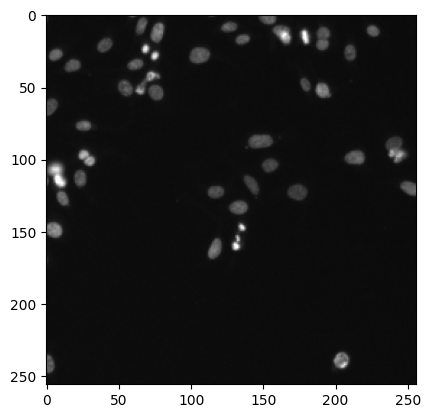

105


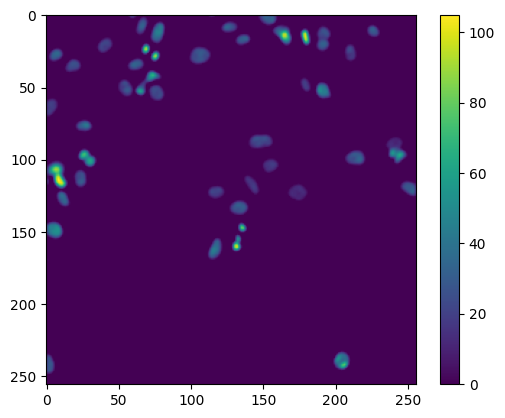

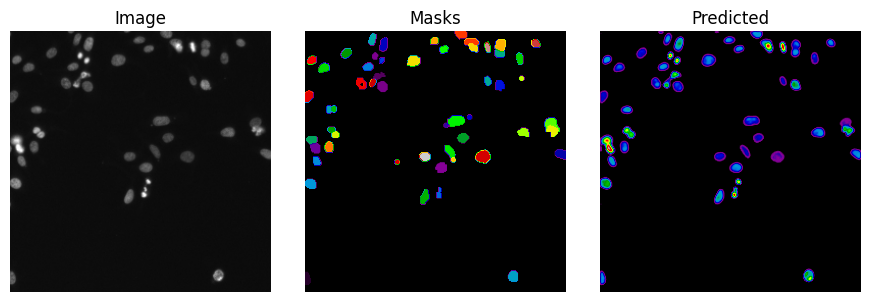

In [ ]:
data = np.load("/content/test/0bda515e370294ed94efd36bd53782288acacb040c171df2ed97fd691fc9d8fe(0,0).npy")
im = data[..., :3]
m = data[..., 3]
plt.imshow(im)
plt.show()
im = torch.Tensor(im).permute(2, 0, 1).to(device).unsqueeze(0)

pred = (net(im).detach().cpu().squeeze().numpy()).astype(np.int64)
print(pred.max())
pred[pred < 0] = 0
plt.imshow(pred)
plt.colorbar()
plt.show()

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(im.squeeze().permute(1, 2, 0).detach().cpu(), cmap=plt.cm.gray)
ax[0].set_title('Image')
ax[1].imshow(m, cmap=plt.cm.nipy_spectral)
ax[1].set_title('Masks')
ax[2].imshow(pred, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Predicted')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

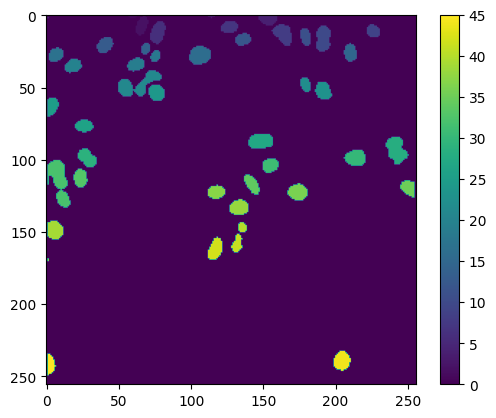

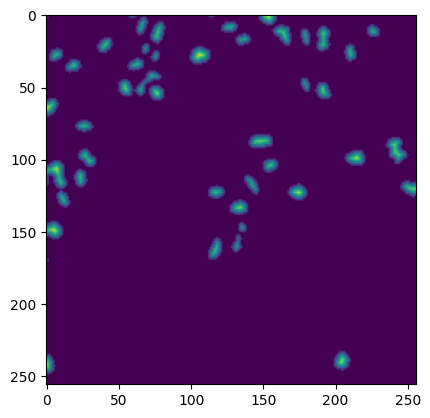

In [ ]:

from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

distance = ndi.distance_transform_edt(pred)
coords = peak_local_max(distance, footprint=np.ones((1, 1)), labels=pred)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)

plt.imshow(markers)
plt.colorbar()
plt.show()
plt.imshow(distance)
plt.show()

46 46 54


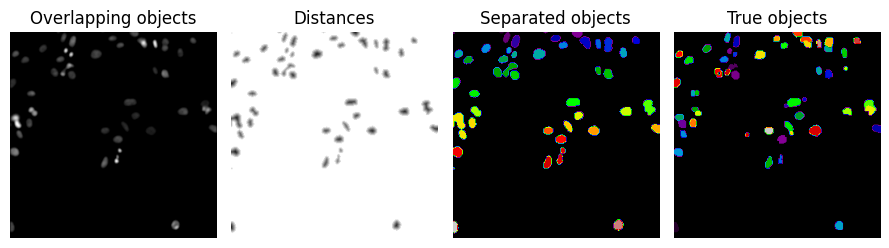

In [ ]:
labels = watershed(-distance, markers, mask=pred)
print(len(np.unique(labels)), len(np.unique(markers)), len(np.unique(m)))

fig, axes = plt.subplots(ncols=4, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(pred, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')
ax[3].imshow(m, cmap=plt.cm.nipy_spectral)
ax[3].set_title('True objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

In [ ]:
def run_test(path):
    data = np.load(path)
    im = data[..., :3]
    m = data[..., 3]
    # plt.imshow(im)
    # plt.show()
    im = torch.Tensor(im).permute(2, 0, 1).to(device).unsqueeze(0)

    pred = (net(im).detach().cpu().squeeze().numpy()).astype(np.int64)
    pred[pred < 0] = 0
    # plt.imshow(pred)
    # plt.colorbar()
    # plt.show()

    # fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
    # ax = axes.ravel()

    # ax[0].imshow(im.squeeze().permute(1, 2, 0).detach().cpu(), cmap=plt.cm.gray)
    # ax[0].set_title('Image')
    # ax[1].imshow(m, cmap=plt.cm.nipy_spectral)
    # ax[1].set_title('Masks')
    # ax[2].imshow(pred, cmap=plt.cm.nipy_spectral)
    # ax[2].set_title('Predicted')

    # for a in ax:
    #     a.set_axis_off()

    # fig.tight_layout()
    # plt.show()
    distance = ndi.distance_transform_edt(pred)
    coords = peak_local_max(distance, footprint=np.ones((1, 1)), labels=pred)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)

    # plt.imshow(markers)
    # plt.colorbar()
    # plt.show()
    # plt.imshow(distance)
    # plt.show()
    labels = watershed(-distance, markers, mask=pred)
    print(len(np.unique(labels)), len(np.unique(markers)), len(np.unique(m)))

    fig, axes = plt.subplots(ncols=4, figsize=(9, 3), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(pred, cmap=plt.cm.gray)
    ax[0].set_title('Overlapping objects')
    ax[1].imshow(-distance, cmap=plt.cm.gray)
    ax[1].set_title('Distances')
    ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
    ax[2].set_title('Separated objects')
    ax[3].imshow(m, cmap=plt.cm.nipy_spectral)
    ax[3].set_title('True objects')

    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    plt.show()
    return get_dice_2(data[..., 3], labels)

File 0b0d577159f0d6c266f360f7b8dfde46e16fa665138bf577ec3c6f9c70c0cd1e(0,245).npy
3 3 3


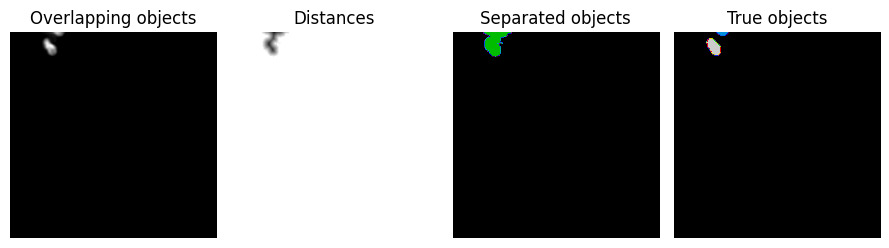

0.42091503267973857
################################################################################
File 00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e(0,0).npy
23 23 65


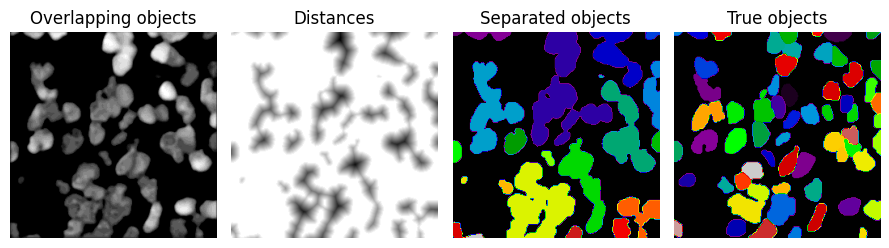

0.2103204439670605
################################################################################
File 0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9(0,0).npy
28 28 28


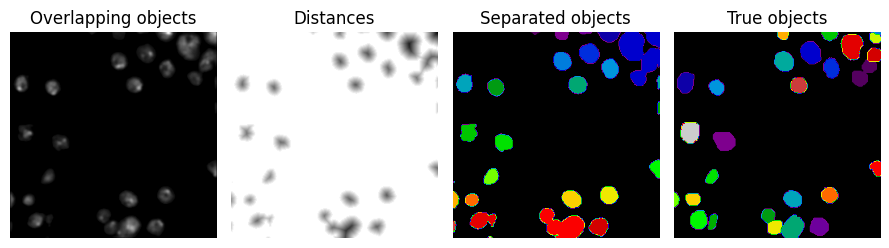

0.5498277188639481
################################################################################
File 0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93(0,0).npy
6 6 6


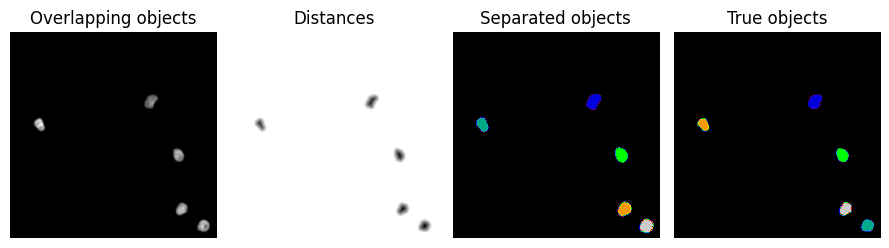

0.9227742252828333
################################################################################
File 0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3(0,0).npy
26 26 53


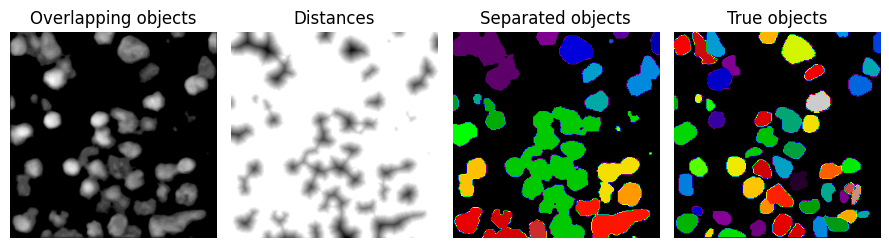

0.20081052197191743
################################################################################
File 0b0d577159f0d6c266f360f7b8dfde46e16fa665138bf577ec3c6f9c70c0cd1e(245,245).npy
45 45 2


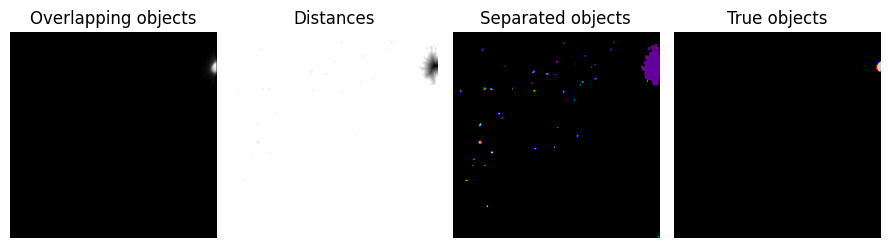

0.1443850267379679
################################################################################
File 0b0d577159f0d6c266f360f7b8dfde46e16fa665138bf577ec3c6f9c70c0cd1e(0,0).npy
5 5 3


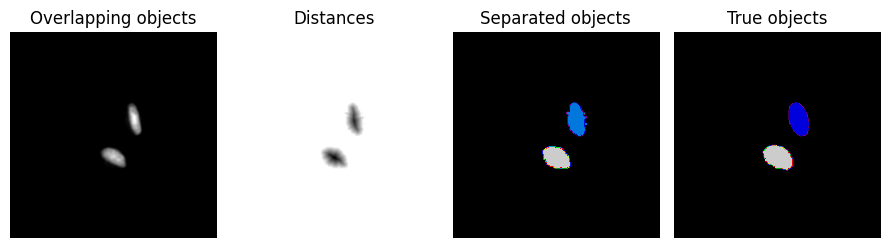

0.6018396846254928
################################################################################
File 0b0d577159f0d6c266f360f7b8dfde46e16fa665138bf577ec3c6f9c70c0cd1e(245,0).npy
2 2 2


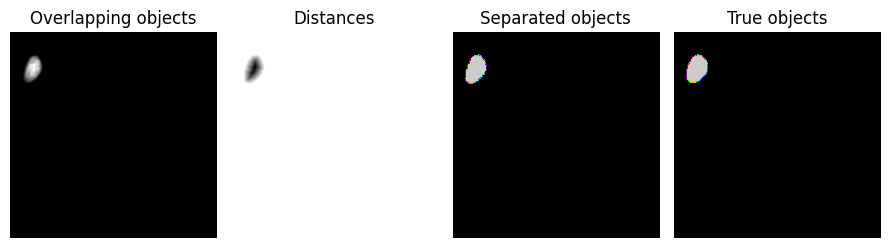

0.9511111111111111
################################################################################
File 0ddd8deaf1696db68b00c600601c6a74a0502caaf274222c8367bdc31458ae7e(0,0).npy
30 30 33


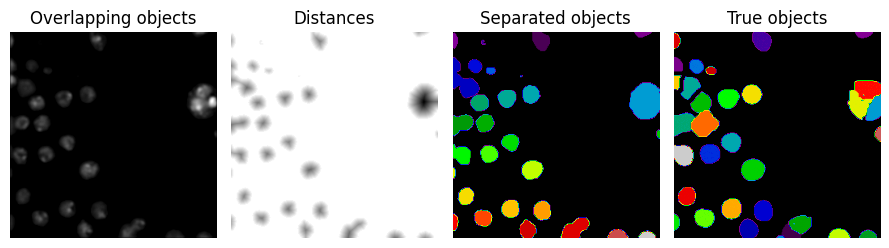

0.663093684989951
################################################################################
File 0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0(0,0).npy
40 40 58


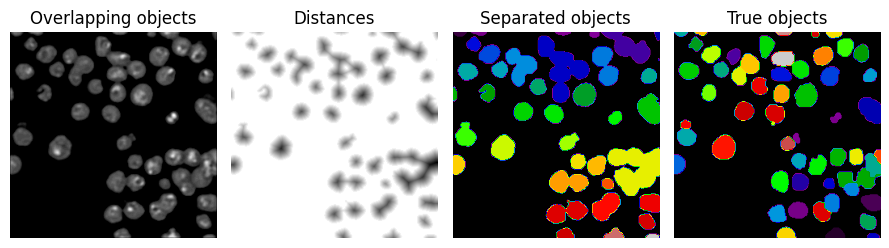

0.4980728900980559
################################################################################
File 0bda515e370294ed94efd36bd53782288acacb040c171df2ed97fd691fc9d8fe(0,0).npy
46 46 54


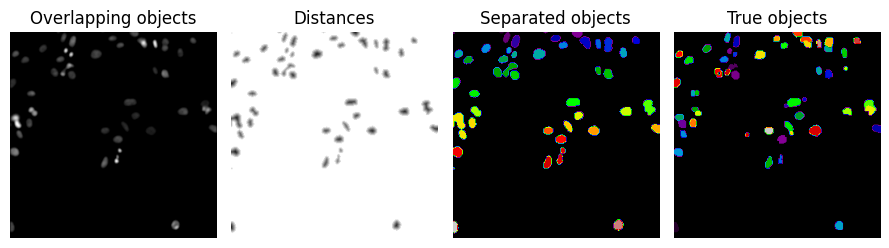

0.7003179650238474
################################################################################
File 0d3640c1f1b80f24e94cc9a5f3e1d9e8db7bf6af7d4aba920265f46cadc25e37(0,0).npy
14 14 19


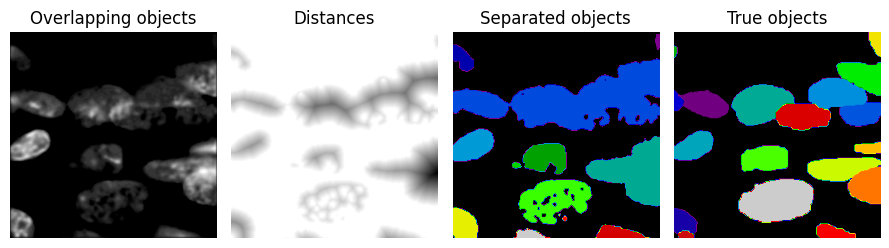

0.31388121041931755
################################################################################
File 0d2bf916cc8de90d02f4cd4c23ea79b227dbc45d845b4124ffea380c92d34c8c(0,0).npy
11 11 11


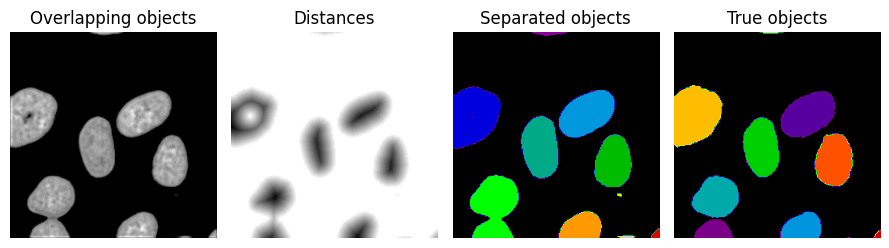

0.8670829114636067
################################################################################
File 0acd2c223d300ea55d0546797713851e818e5c697d073b7f4091b96ce0f3d2fe(0,0).npy
10 10 10


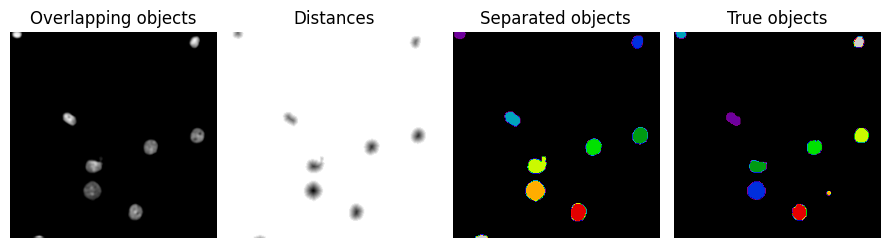

0.8999521302058401
################################################################################
File 0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6(0,0).npy
25 25 27


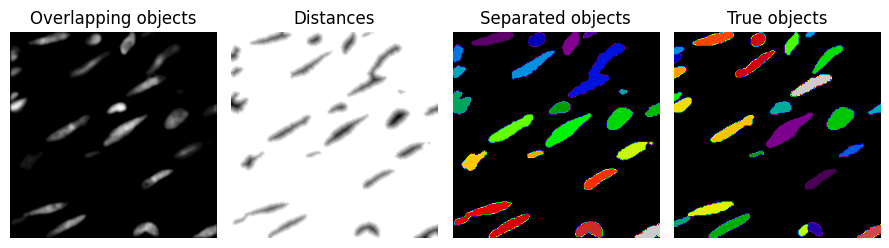

0.7657683215130023
################################################################################
File 0c2550a23b8a0f29a7575de8c61690d3c31bc897dd5ba66caec201d201a278c2(0,0).npy
26 26 57


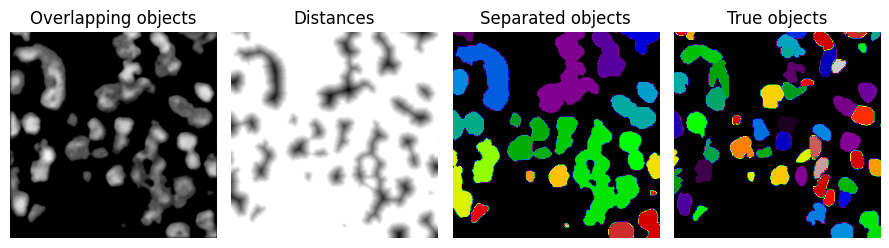

0.2852095366842817
################################################################################
File 0c6507d493bf79b2ba248c5cca3d14df8b67328b89efa5f4a32f97a06a88c92c(0,0).npy
28 28 29


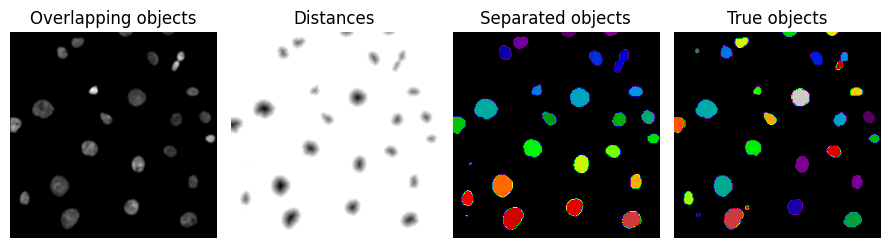

0.882477587612062
################################################################################
Mean dice2 for images in test: 0.5810494119558844


In [ ]:
ret = []
for i in os.listdir('test'):
    print(f"File {i}")
    dice = run_test('test/'+i)
    print(dice)
    ret.append(dice)
    print("#" * 80)

print(f"Mean dice2 for images in test: {np.mean(ret)}")

In [ ]:

from torchmetrics.detection import MeanAveragePrecision
metric = MeanAveragePrecision(iou_type='segm')
metric(pred, m)

In [ ]:

####
def get_dice_2(true, pred):
    """Ensemble Dice as used in Computational Precision Medicine Challenge."""
    true = np.copy(true)
    pred = np.copy(pred)
    true_id = list(np.unique(true))
    pred_id = list(np.unique(pred))
    # remove background aka id 0
    true_id.remove(0)
    pred_id.remove(0)

    total_markup = 0
    total_intersect = 0
    for t in true_id:
        t_mask = np.array(true == t, np.uint8)
        for p in pred_id:
            p_mask = np.array(pred == p, np.uint8)
            intersect = p_mask * t_mask
            if intersect.sum() > 0:
                total_intersect += intersect.sum()
                total_markup += t_mask.sum() + p_mask.sum()
    return 2 * total_intersect / total_markup

get_dice_2(m, labels)


0.7003179650238474